In [2]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

## Minimum Variance Portfolio Backtest.

In [3]:
from qamsi.config.trading_config import TradingConfig
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from run import Dataset, initialize

In [4]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 30
ESTIMATION_WINDOW = 365

ESTIMATOR = CovEstimators.RF.value(shrinkage_type="linear")

In [5]:
trading_config = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=1,
)

preprocessor, runner = initialize(
    dataset=DATASET,
    trading_config=trading_config,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [6]:
strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Computing Weights: 100%|██████████| 283/283 [04:05<00:00,  1.15it/s]


StrategyStatistics:
* final_nav = 13.165822
* geom_avg_total_r = 0.145193
* geom_avg_xs_r = 0.125896
* std_xs_r = 0.148149
* min_xs_r = -0.080049
* max_xs_r = 0.102284
* skew = 0.081343
* kurtosis = 13.524097
* max_dd = -0.263874
* sharpe = 0.849793
* alpha_buy_hold = 0.067621
* tracking_error_buy_hold = 0.147116
* ir_buy_hold = 0.459644
* factor_loadings = {'low_risk': 0.5276481328770457, 'momentum': -0.052933214295441094, 'quality': 0.13229491469313778, 'size': 0.055024185281644836, 'value': -0.2063058276198756, 'spx': 0.722993320087308}
* alpha_benchmark = 0.064628
* alpha_benchmark_pvalue = 0.002185
* tracking_error_benchmark = 0.087806
* ir_benchmark = 0.736025
* ttest_pval = 0.208412
* levene_pval = 0.000000
* timing_ability_coef = -0.027309
* timing_ability_pval = 0.091957

In [7]:
result.std_xs_r, result.sharpe

(0.14814885606738049, 0.8497925762025326)

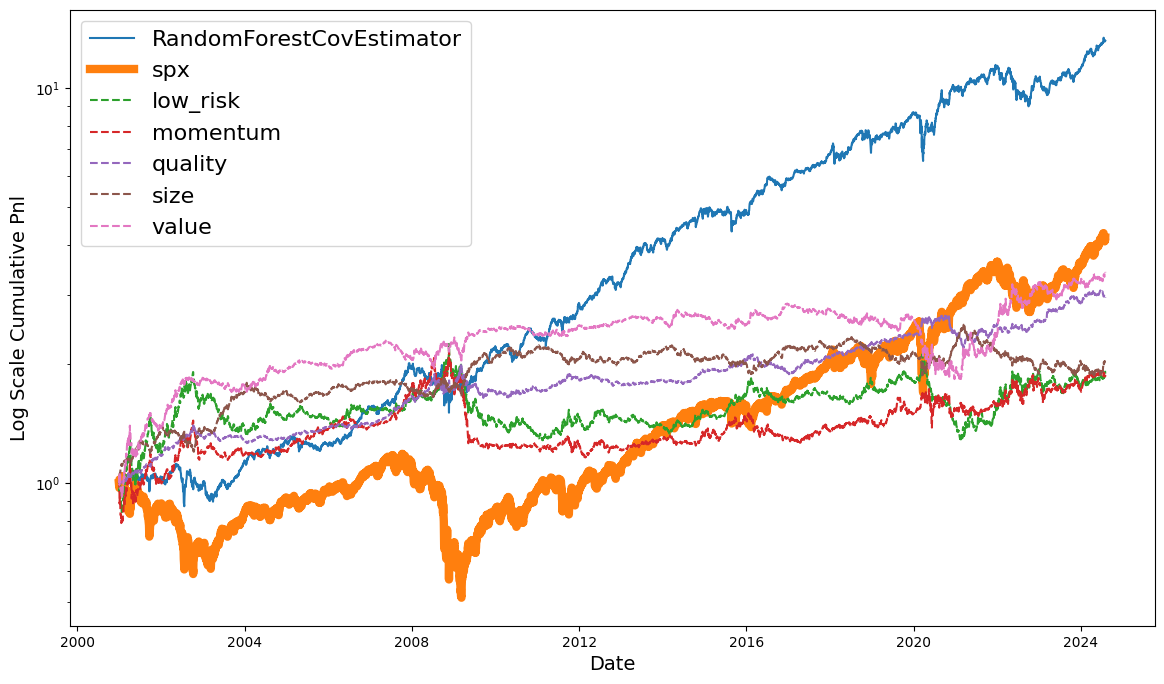

In [8]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

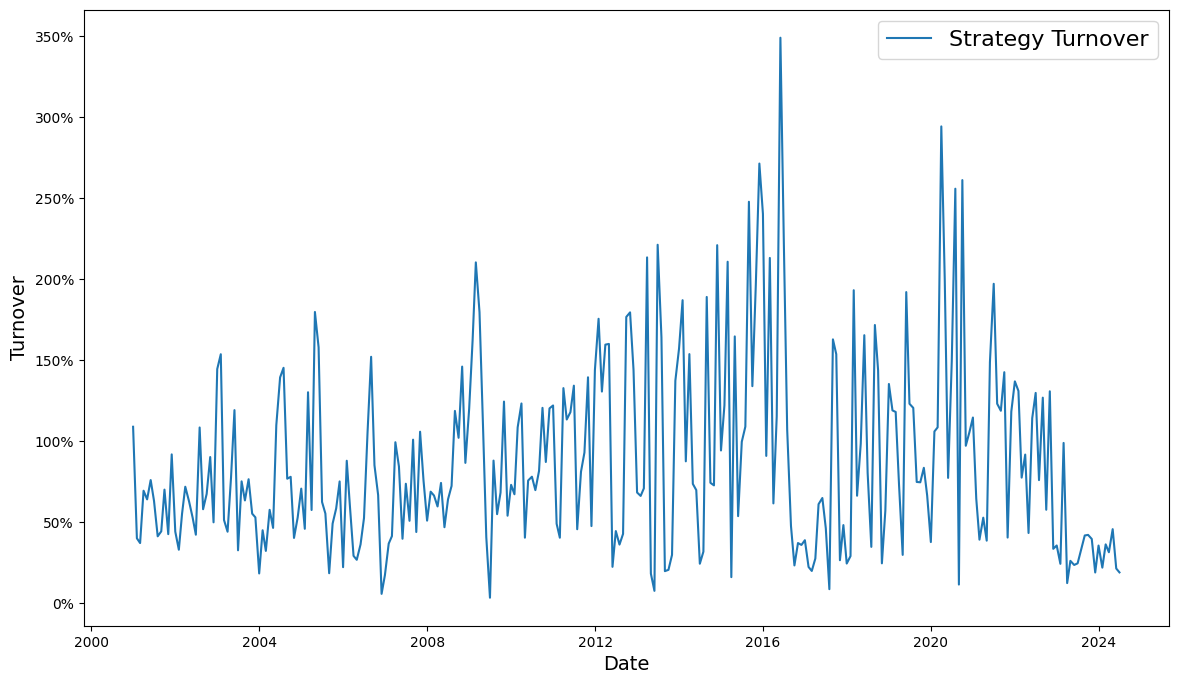

In [9]:
runner.plot_turnover()

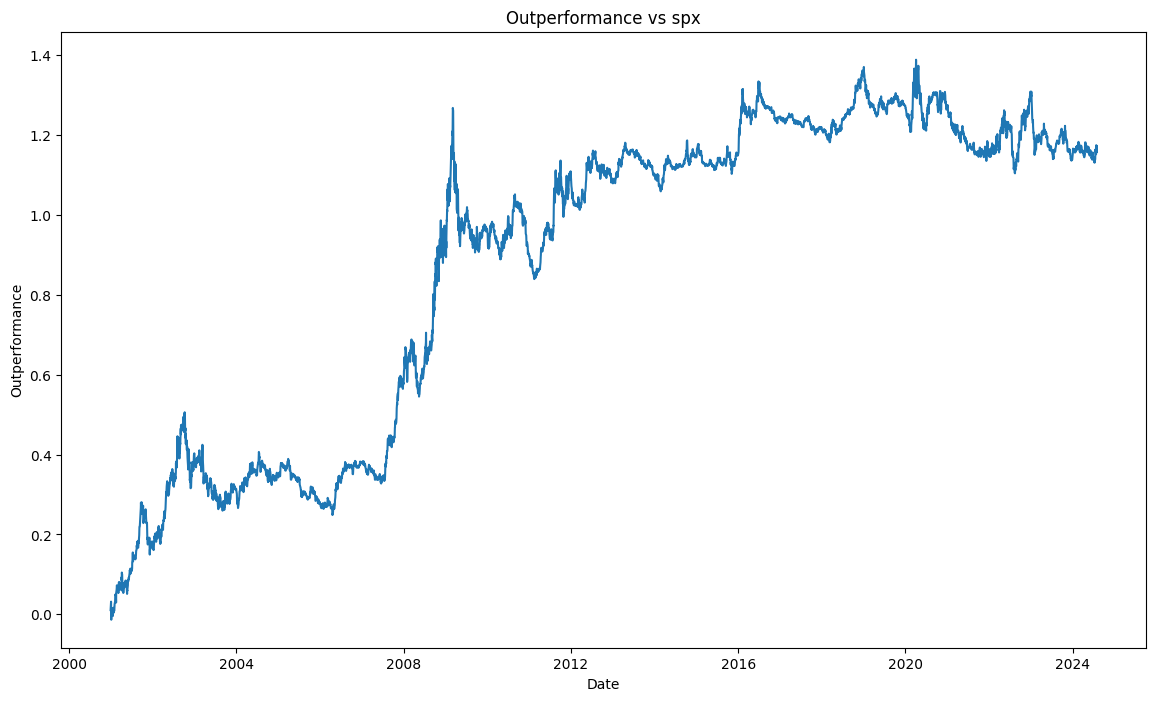

In [10]:
runner.plot_outperformance(mkt_only=True)

In [11]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")

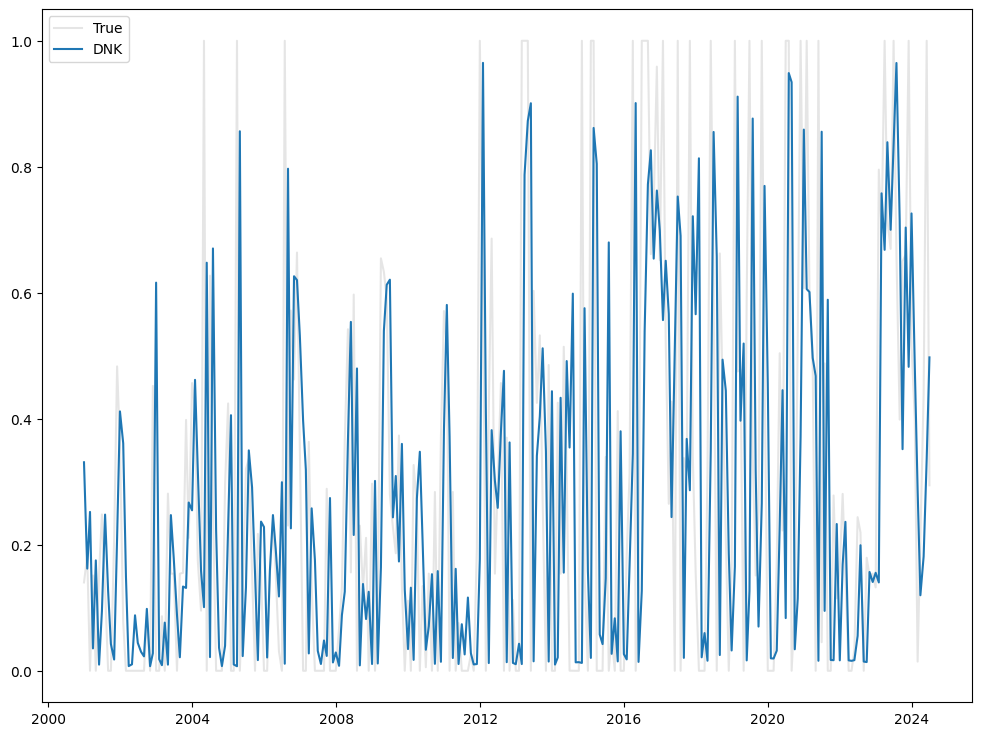

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))

pred = ESTIMATOR.predictions

targets = runner.targets.loc[pred.index, "target"]
# ma = runner.features.loc[pred.index, "target_rolling_mean"].shift(1)

plt.plot(
    targets.index,
    targets.to_numpy(),
    label="True",
    color="grey",
    alpha=0.2,
)
plt.plot(pred.index, pred.to_numpy(), label=f"{ESTIMATOR.name}")
# plt.plot(ma.index, ma.to_numpy(), label="MA")

plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(targets, pred)

0.25518934853906716

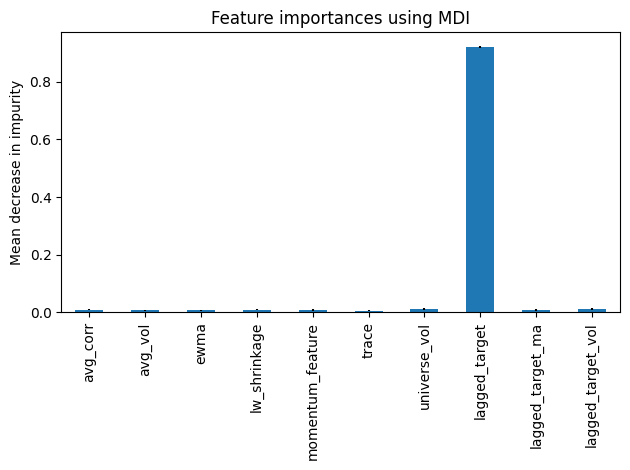

In [15]:
import numpy as np
import pandas as pd

feature_names = runner.features.columns.tolist() + [
    "lagged_target",
    "lagged_target_ma",
    "lagged_target_vol",
]
importances = ESTIMATOR.rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in ESTIMATOR.rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

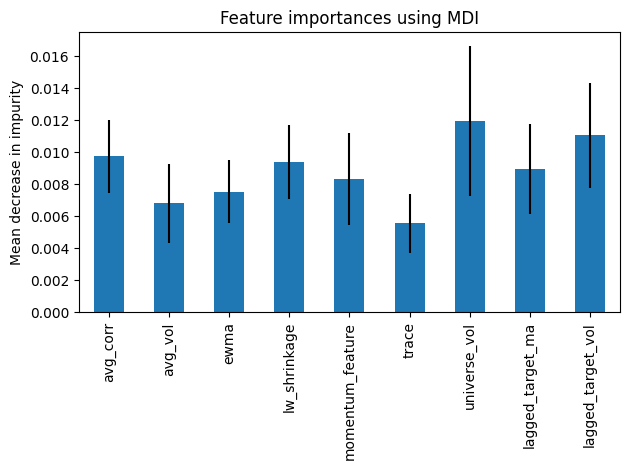

In [16]:
fig, ax = plt.subplots()
forest_importances.drop("lagged_target").plot.bar(
    yerr=np.concatenate([std[:6], std[7:]]), ax=ax
)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

(
    (targets.to_numpy() - pred.to_numpy()).mean(),
    mean_absolute_error(targets, pred),
    mean_squared_error(targets, pred),
)

(0.014227030420918467, 0.25518934853906716, 0.12644219725345654)

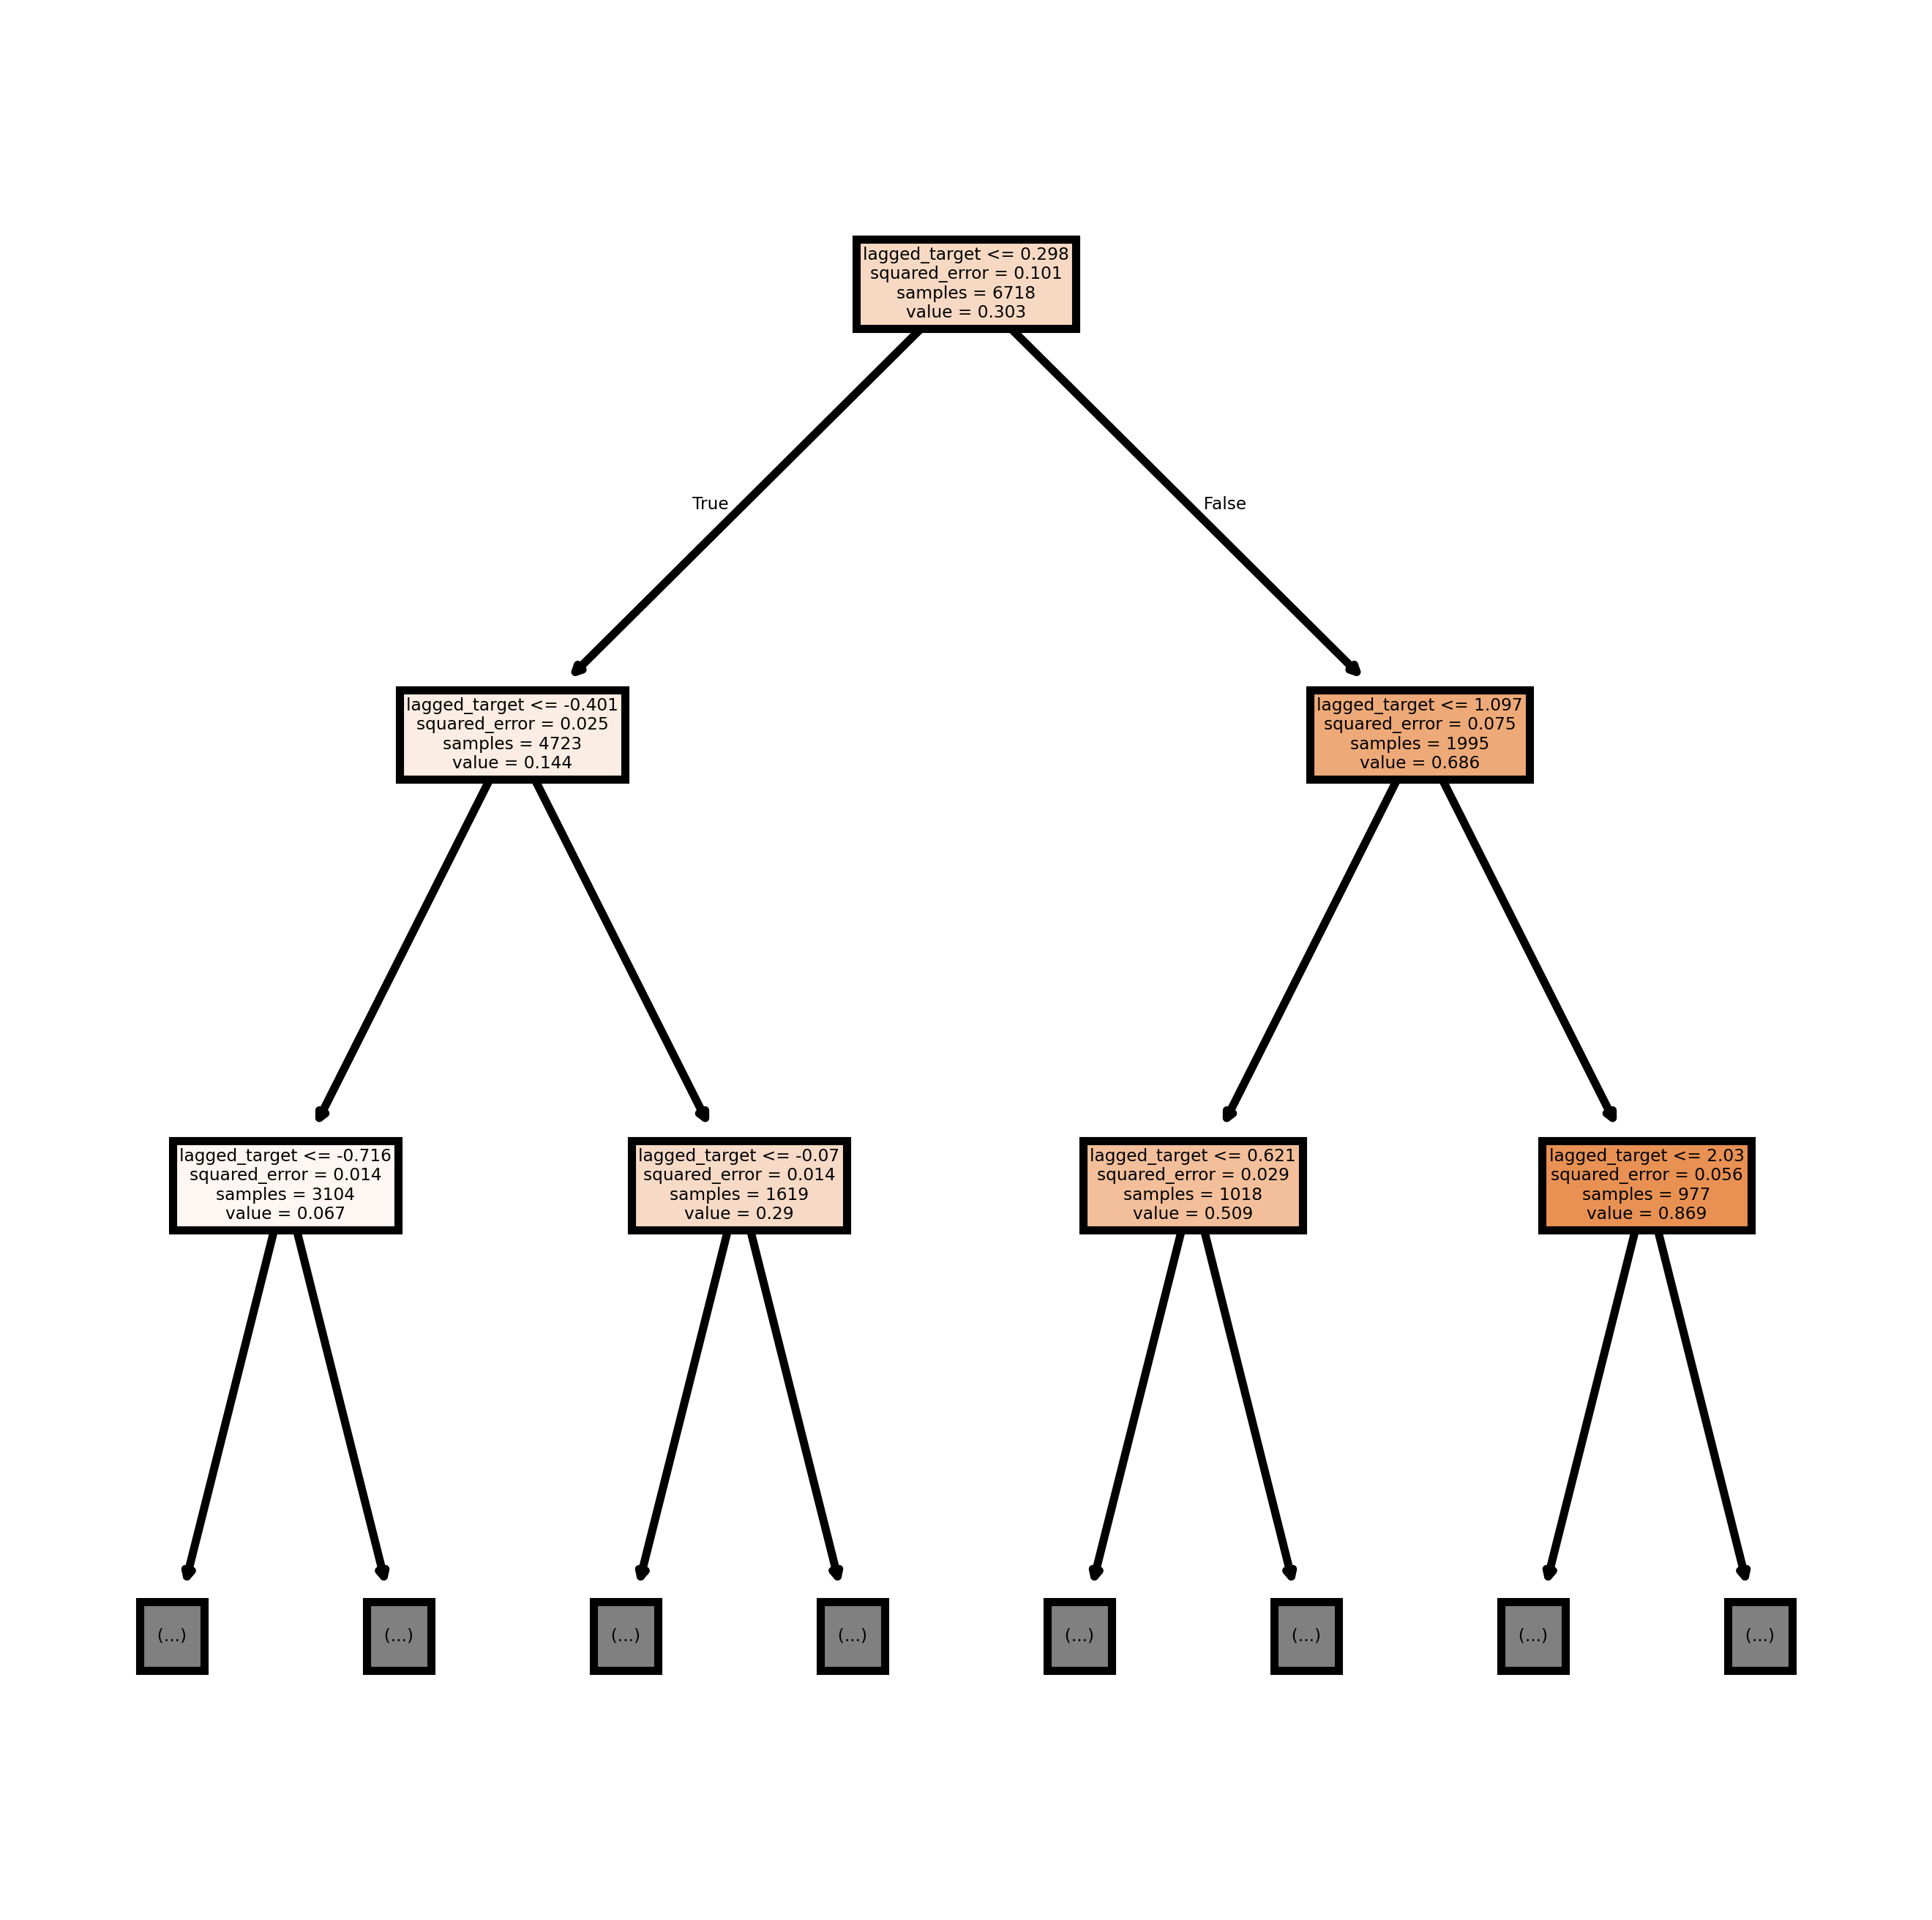

In [18]:
from sklearn import tree

rf = ESTIMATOR.rf
fn = feature_names
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=800)
tree.plot_tree(
    rf.estimators_[0],
    feature_names=fn,
    filled=True,
    max_depth=2,
);
# fig.savefig('rf_individualtree.png')